Loading data...

=== Exploratory Data Analysis ===

Basic Dataset Information:
Training set shape: (48439, 8)
Test set shape: (3, 5)

Columns: ['id', 'prompt', 'response_a', 'response_b', 'winner', 'model_a', 'model_b', 'language']


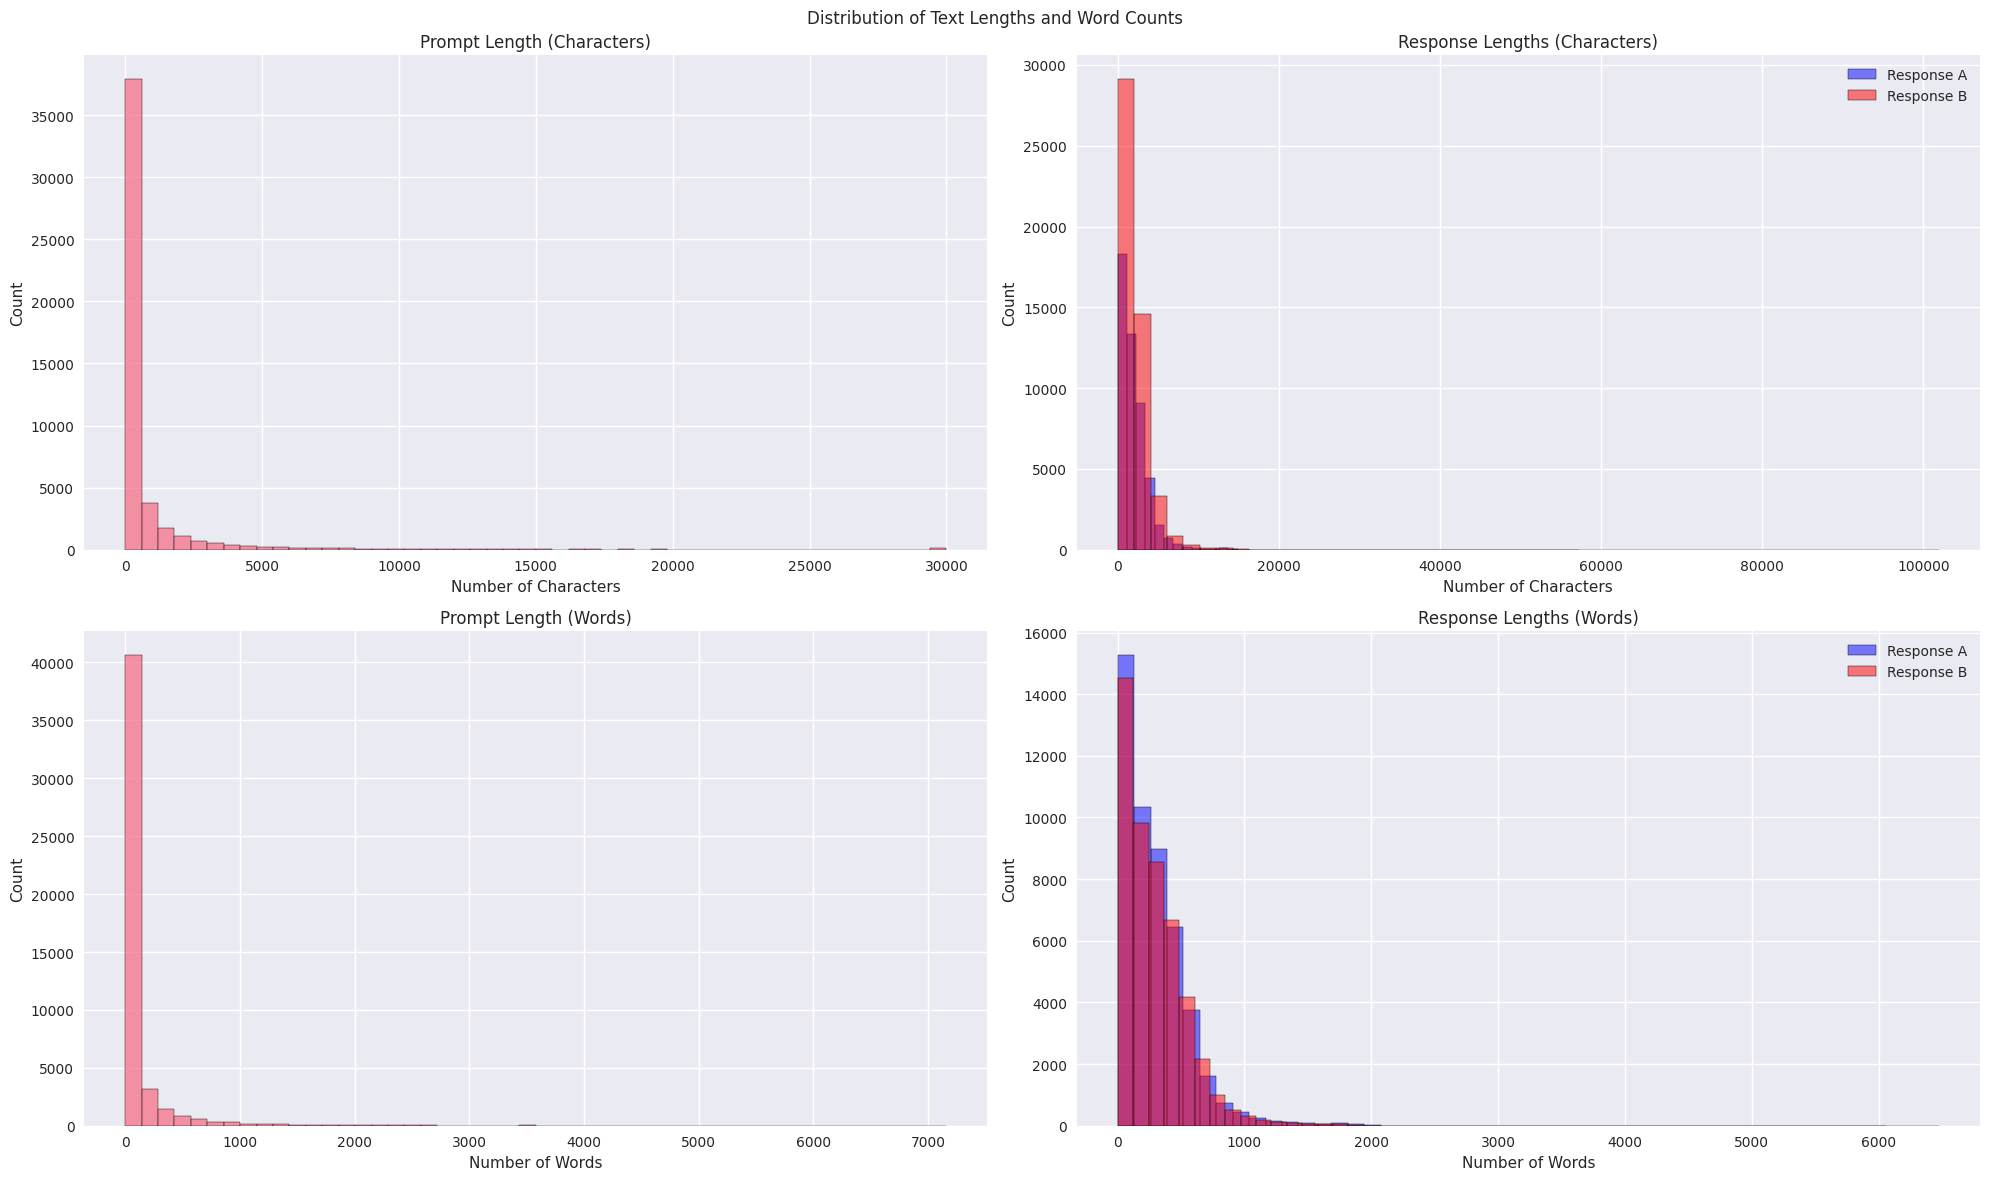

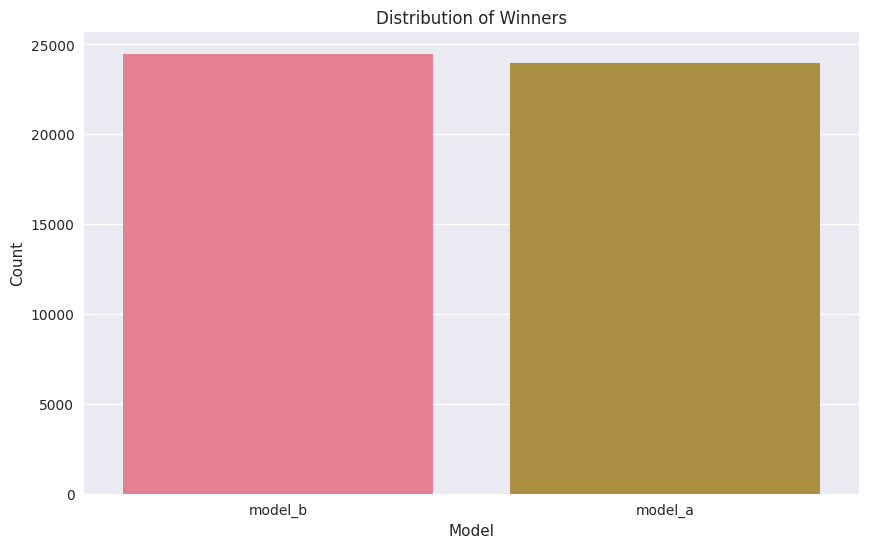

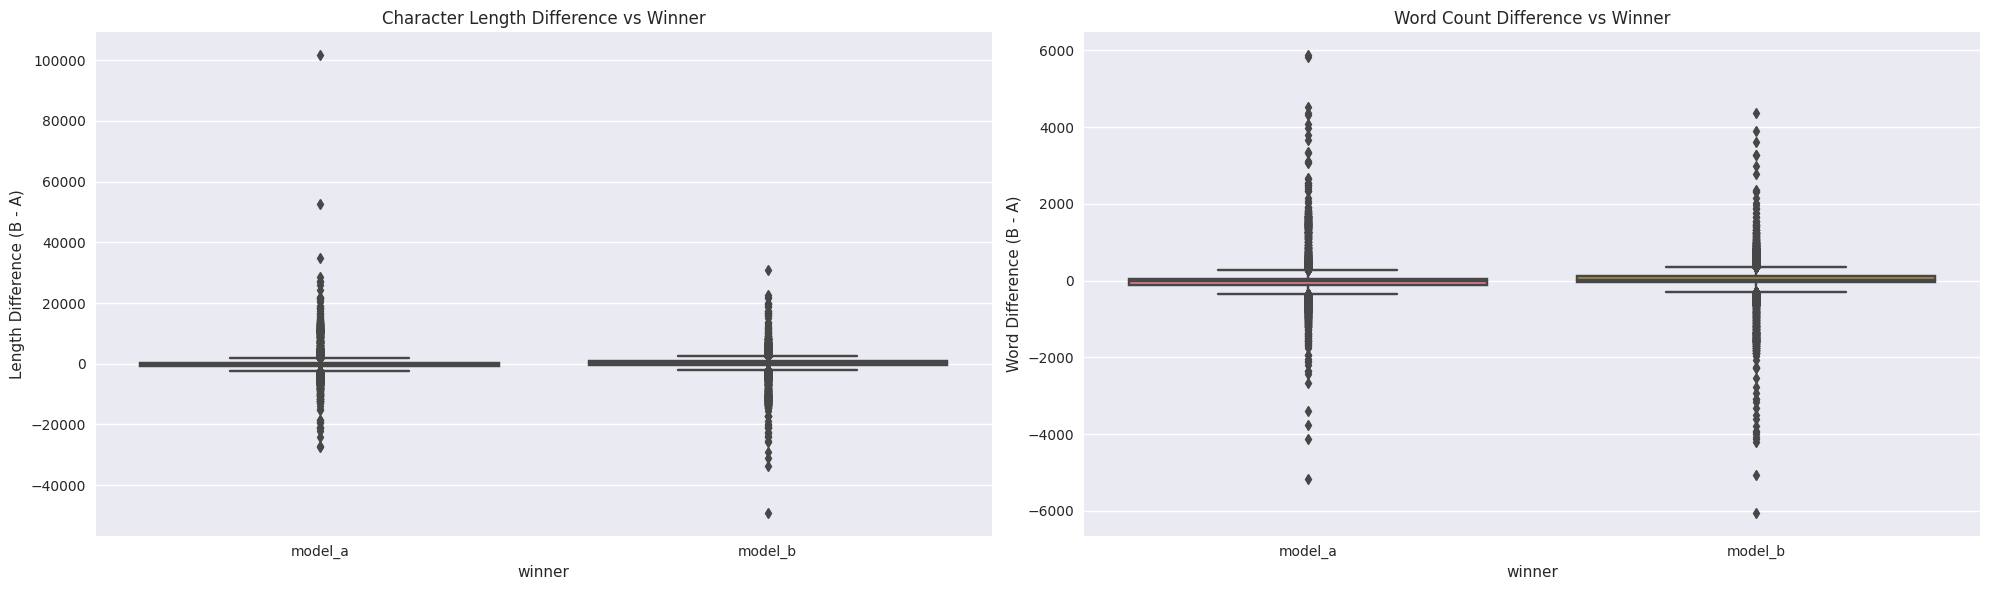


=== Summary Statistics ===

Total conversations: 48439

Character Length Statistics:
Average prompt length: 875.57 characters
Average response A length: 2015.56 characters
Average response B length: 2020.37 characters

Word Count Statistics:
Average prompt words: 121.66 words
Average response A words: 293.45 words
Average response B words: 294.14 words

=== Model Development ===

Preprocessing text data...
Transforming features...

Training XGBoost model...
[0]	validation_0-logloss:0.68732
[62]	validation_0-logloss:0.65314

Model Evaluation:

Validation Metrics:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      4792
           1       0.61      0.61      0.61      4896

    accuracy                           0.61      9688
   macro avg       0.61      0.61      0.61      9688
weighted avg       0.61      0.61      0.61      9688



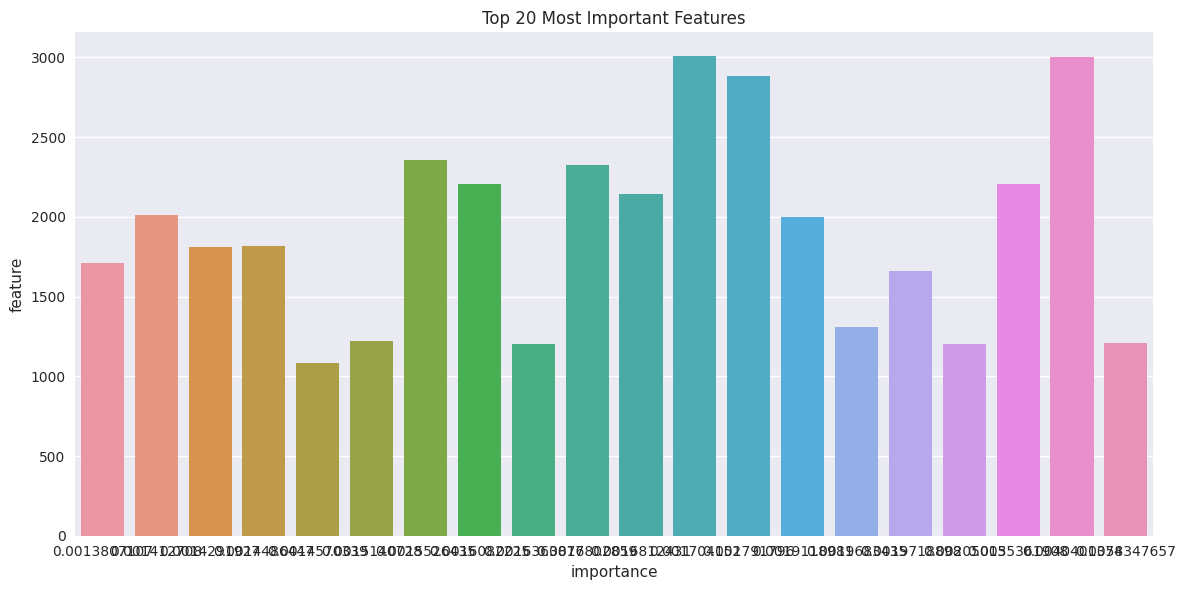


Generating predictions for test set...

Creating submission file...

Contents of saved submission file:
     id  winner
 327228 model_b
1139415 model_b
1235630 model_a

=== Final Summary ===
Model validation accuracy: 0.6068
Number of features used: 3008
Submission file contains predictions for 3 samples


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style and random seed
plt.style.use('seaborn')
sns.set_palette("husl")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Load Data
print("Loading data...")
train_df = pd.read_parquet('../input/wsdm-cup-multilingual-chatbot-arena/train.parquet')
test_df = pd.read_parquet('../input/wsdm-cup-multilingual-chatbot-arena/test.parquet')

###################
# Part 1: EDA
###################

print("\n=== Exploratory Data Analysis ===")

# 1. Basic Dataset Information
print("\nBasic Dataset Information:")
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print("\nColumns:", train_df.columns.tolist())

# 2. Text Length Analysis
def get_text_stats(df):
    stats_df = df.copy()
    stats_df['prompt_length'] = df['prompt'].str.len()
    stats_df['response_a_length'] = df['response_a'].str.len()
    stats_df['response_b_length'] = df['response_b'].str.len()
    stats_df['length_diff'] = stats_df['response_b_length'] - stats_df['response_a_length']
    
    # Add word count features
    stats_df['prompt_words'] = df['prompt'].str.split().str.len()
    stats_df['response_a_words'] = df['response_a'].str.split().str.len()
    stats_df['response_b_words'] = df['response_b'].str.split().str.len()
    stats_df['word_diff'] = stats_df['response_b_words'] - stats_df['response_a_words']
    
    return stats_df

train_stats = get_text_stats(train_df)
test_stats = get_text_stats(test_df)

# Visualize length distributions
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Distribution of Text Lengths and Word Counts')

# Character lengths
sns.histplot(data=train_stats, x='prompt_length', bins=50, ax=axes[0,0])
axes[0,0].set_title('Prompt Length (Characters)')
axes[0,0].set_xlabel('Number of Characters')

sns.histplot(data=train_stats, x='response_a_length', 
             bins=50, color='blue', alpha=0.5, 
             label='Response A', ax=axes[0,1])
sns.histplot(data=train_stats, x='response_b_length', 
             bins=50, color='red', alpha=0.5,
             label='Response B', ax=axes[0,1])
axes[0,1].set_title('Response Lengths (Characters)')
axes[0,1].set_xlabel('Number of Characters')
axes[0,1].legend()

# Word counts
sns.histplot(data=train_stats, x='prompt_words', bins=50, ax=axes[1,0])
axes[1,0].set_title('Prompt Length (Words)')
axes[1,0].set_xlabel('Number of Words')

sns.histplot(data=train_stats, x='response_a_words', 
             bins=50, color='blue', alpha=0.5, 
             label='Response A', ax=axes[1,1])
sns.histplot(data=train_stats, x='response_b_words', 
             bins=50, color='red', alpha=0.5,
             label='Response B', ax=axes[1,1])
axes[1,1].set_title('Response Lengths (Words)')
axes[1,1].set_xlabel('Number of Words')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# 3. Winner Distribution
plt.figure(figsize=(10, 6))
winner_dist = train_df['winner'].value_counts()
sns.barplot(x=winner_dist.index, y=winner_dist.values)
plt.title('Distribution of Winners')
plt.xlabel('Model')
plt.ylabel('Count')
plt.show()

# 4. Length and Word Count Differences vs Winner Analysis
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.boxplot(x='winner', y='length_diff', data=train_stats, ax=axes[0])
axes[0].set_title('Character Length Difference vs Winner')
axes[0].set_ylabel('Length Difference (B - A)')

sns.boxplot(x='winner', y='word_diff', data=train_stats, ax=axes[1])
axes[1].set_title('Word Count Difference vs Winner')
axes[1].set_ylabel('Word Difference (B - A)')

plt.tight_layout()
plt.show()

# Print Summary Statistics
print("\n=== Summary Statistics ===")
print(f"\nTotal conversations: {len(train_df)}")
print("\nCharacter Length Statistics:")
print(f"Average prompt length: {train_stats['prompt_length'].mean():.2f} characters")
print(f"Average response A length: {train_stats['response_a_length'].mean():.2f} characters")
print(f"Average response B length: {train_stats['response_b_length'].mean():.2f} characters")
print("\nWord Count Statistics:")
print(f"Average prompt words: {train_stats['prompt_words'].mean():.2f} words")
print(f"Average response A words: {train_stats['response_a_words'].mean():.2f} words")
print(f"Average response B words: {train_stats['response_b_words'].mean():.2f} words")

###################
# Part 2: Modeling
###################

print("\n=== Model Development ===")

# Prepare target variable
train_df['winner'] = train_df['winner'].map({
    'model_a': 0,
    'model_b': 1
})

# Feature Engineering
print("\nPreprocessing text data...")
preprocessor = ColumnTransformer(
    transformers=[
        ('prompt', TfidfVectorizer(analyzer='char_wb', 
                                 max_features=1000, 
                                 ngram_range=(2,4)), 'prompt'),
        ('response_a', TfidfVectorizer(analyzer='char_wb', 
                                     max_features=1000, 
                                     ngram_range=(2,4)), 'response_a'),
        ('response_b', TfidfVectorizer(analyzer='char_wb', 
                                     max_features=1000, 
                                     ngram_range=(2,4)), 'response_b')
    ]
)

# Add length-based features
def add_length_features(vectors, stats_df):
    length_features = stats_df[['prompt_length', 'response_a_length', 
                               'response_b_length', 'length_diff',
                               'prompt_words', 'response_a_words',
                               'response_b_words', 'word_diff']].values
    return np.hstack([vectors.toarray(), length_features])

# Create train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    train_df[['prompt', 'response_a', 'response_b']],
    train_df['winner'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=train_df['winner']
)

# Transform the data
print("Transforming features...")
X_train_vec = preprocessor.fit_transform(X_train)
X_val_vec = preprocessor.transform(X_val)
test_vectors = preprocessor.transform(test_df)

# Add length features
X_train_full = add_length_features(X_train_vec, get_text_stats(X_train))
X_val_full = add_length_features(X_val_vec, get_text_stats(X_val))
test_full = add_length_features(test_vectors, get_text_stats(test_df))

# Train model
print("\nTraining XGBoost model...")
clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED
)

clf.fit(
    X_train_full,
    y_train,
    eval_set=[(X_val_full, y_val)],
    eval_metric='logloss',
    early_stopping_rounds=20,
    verbose=100
)

# Evaluate model
print("\nModel Evaluation:")
val_predictions = clf.predict(X_val_full)
print("\nValidation Metrics:")
print(classification_report(y_val, val_predictions))

# Feature importance analysis
n_features = 20
feature_importance = pd.DataFrame({
    'feature': range(X_train_full.shape[1]),
    'importance': clf.feature_importances_
})
top_features = feature_importance.nlargest(n_features, 'importance')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_features, x='importance', y='feature')
plt.title(f'Top {n_features} Most Important Features')
plt.tight_layout()
plt.show()

# Generate predictions for submission
print("\nGenerating predictions for test set...")
test_predictions = clf.predict(test_full)
test_predictions = np.where(test_predictions == 0, 'model_a', 'model_b')

# Create submission file
print("\nCreating submission file...")
submission = pd.DataFrame({
    'id': [327228, 1139415, 1235630],
    'winner': test_predictions[:3]
})

# Save submission without index
submission.to_csv('submission.csv', index=False)

# Verify the saved file
print("\nContents of saved submission file:")
print(pd.read_csv('submission.csv').to_string(index=False))

# Print final summary
print("\n=== Final Summary ===")
print(f"Model validation accuracy: {accuracy_score(y_val, val_predictions):.4f}")
print(f"Number of features used: {X_train_full.shape[1]}")
print("Submission file contains predictions for", len(test_predictions), "samples")